In this plot, I want to make a plot summarizing the large spectroscopic dwarf galaxy surveys we have available and where DESI lies in this space ...

Inspired by the SAGA survey plot

In [1]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist
from desi_lowz_funcs import find_objects_nearby
from construct_dwarf_galaxy_catalogs import process_sga_matches


In [2]:
Table.read("/pscratch/sd/v/virajvm/data_to_share/desi_y1_dwarf_combine_catalog.fits")

TARGETID,SURVEY,PROGRAM,HEALPIX,TILEID_LIST,RA,DEC,Z,ZWARN,DELTACHI2,SPECTYPE,Z_RR,TSNR2_QSO,TSNR2_LYA,PHOTSYS,LS_ID,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,EBV,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,MAG_G_DR9,MAG_R_DR9,MAG_Z_DR9,MAG_W1,MAG_W2,MAG_G_ERR_DR9,MAG_R_ERR_DR9,MAG_Z_ERR_DR9,MAG_W1_ERR,MAG_W2_ERR,OBJID,BRICKNAME,SIGMA_G,FRACFLUX_G,RCHISQ_G,SIGMA_GOOD_G,SIGMA_R,FRACFLUX_R,RCHISQ_R,SIGMA_GOOD_R,SIGMA_Z,FRACFLUX_Z,RCHISQ_Z,SIGMA_GOOD_Z,SHAPE_R,SHAPE_R_ERR,MU_R,MU_R_ERR,SERSIC,SERSIC_IVAR,BA,TYPE,PHI,FIBERMAG_R,MASKBITS,LOGM_SAGA_DR9,LOGM_M24_DR9,SWEEP,is_south,STARFDIST,STARDIST_DEG,STARMAG,STAR_RADIUS_ARCSEC,STAR_RA,STAR_DEC,SAMPLE,SGA_ID_MATCH,SGA_D26_NORM_DIST,SGA_DIST_DEG,IMAGE_PATH,FILE_PATH,MAG_G_APERTURE_COG,MAG_R_APERTURE_COG,MAG_Z_APERTURE_COG,MAG_G_APERTURE_COG_ERR,MAG_R_APERTURE_COG_ERR,MAG_Z_APERTURE_COG_ERR,MAG_G_APERTURE_COG_PARAMS,MAG_R_APERTURE_COG_PARAMS,MAG_Z_APERTURE_COG_PARAMS,MAG_G_APERTURE_COG_PARAMS_ERR,MAG_R_APERTURE_COG_PARAMS_ERR,MAG_Z_APERTURE_COG_PARAMS_ERR,LOGM_SAGA_APERTURE_COG,PCNN_FRAGMENT,NEAREST_STAR_NORM_DIST,MAG_G_APERTURE_R4,MAG_R_APERTURE_R4,MAG_Z_APERTURE_R4,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_Z,MAG_Z_ERR,LOGM_SAGA,HALPHA_FLUX,HALPHA_FLUX_IVAR,SNR_B,SNR_R,SNR_Z,HALPHA_EW,HALPHA_EW_IVAR
int64,bytes7,bytes6,int32,bytes47,float64,float64,float64,int64,float64,bytes6,float64,float32,float32,bytes1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,float32,float32,int16,float64,float64,bytes29,int64,float32,float32,float32,float32,float32,float32,bytes10,int64,float64,float64,bytes128,bytes128,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32
2705768184807424,main,dark,36536,9000,26.297520239937864,-17.49630781690451,0.04168615908531031,0,10897.993870973587,GALAXY,0.04168615908531031,30.47157,114.747856,S,9906614915961571,3.4761426,4.830554,5.5868316,3.4761426,4.830554,5.5868316,13.562651,18.53078,21.104635,9.915407,5.7323976,45.03719,-1333.3851,684.10626,513.34564,70.903885,2.6294007,0.5995027,0.00073518214,1.1134064e-05,0.017517118,0.94946724,0.9656732,0.9806515,0.99703574,0.99817854,0.99961126,0.9998532,19.669138,19.330265,19.189054,20.009224,20.604158,0.003064243,0.0025889932,0.006116693,0.06760683,0.24490501,4835,0262m175,336.81107,7.7730736e-05,1.2878373,336.81107,405.4421,9.51154e-05,1.3370961,405.4421,174.27199,0.00057945837,1.1348885,174.27199,1.4914808,0.0038830705,22.193804,0.0062169316,1.8201447,2832.198,0.5307464,SER,-72.414,20.790009,0,8.449100648894259,8.599334905096672,sweep-020m020-030m015-pz.fits,1,99.0,99.0,99.0,99.0,99.0,99.0,LOWZ,424921,15.393006147049276,0.08862665437342995,/pscratch/sd/v/virajvm/redo_photometry_plots/all_good_cutouts/image_tgid_2705768184807424_ra_26.297520_dec_-17.496308.fits,/pscratch/sd/v/virajvm/redo_photometry_plots/all_good/south/sweep-020m020-030m015/0262m175/LOWZ_tgid_2705768184807424,--,--,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,--,--,19.669137954711914,0.0030642428901046515,19.330265045166016,0.0025889931712299585,19.189054489135742,0.006116692908108234,8.449100648894259,106.626976,0.593151

In [7]:
# "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits"

In [61]:
sga_file = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_lowz_filter_zsucc_zrr03.fits"
# sga_file = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits"
sga_data = Table.read(sga_file)
print(len(sga_data))


# 3.7276929076217766 7.829928665080762
# Hmm. The target source was not found.
# 3.9708884231531023 8.125161029663763
# Hmm. The target source was not found.


103032


In [62]:
# sga_data[sga_data["TARGETID"] == 2715759084044288]

print(len(sga_data))

print(len(np.unique(sga_data["TARGETID"])))

103032
102610


In [63]:
find_objects_nearby(sga_data, 46.99331151369161, -0.03734963080522349 ,ra="RA",dec="DEC" )["OBJID","BRICKID"]

OBJID,BRICKID
int32,int32
5503,0


In [64]:
find_objects_nearby(sga_data,264.257,59.803,ra="RA",dec="DEC" )["IMAGE_PATH"]

KeyError: 'IMAGE_PATH'

In [ ]:
# https://www.legacysurvey.org/viewer-dev/cutout.fits?ra=136.77617421739058&dec=32.371961902778565&size=1063&layer=ls-dr9&pixscale=0.262&bands=grz&invvar&maskbits




In [ ]:
mag_diffs = np.abs(sga_data["MAG_R"].data - sga_data["SGA_R_COG_MAG"].data)

In [257]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")

print(len(temp))

5325


In [249]:
# def get_subset_five_sga(tot_cat,rmag_min=19,rmag_max = 20):
#     rmag_mask = (tot_cat["MAG_R_APERTURE_COG"] > rmag_min) & (tot_cat["MAG_R_APERTURE_COG"] < rmag_max) & (tot_cat["Z"] < 0.005)

#     tot_cat_i = tot_cat[rmag_mask]

#     rnd_inds = np.random.randint(len(tot_cat_i),size = 100)

#     print_radecs(tot_cat_i[rnd_inds],ra="RA",dec="DEC")
    
#     return 


In [258]:
bad_fit_mask = ((temp["NEAREST_STAR_NORM_DIST"] < 1) | (temp["STARFDIST"] < 1) | (temp["G_APERTURE_COG_CHI2"] > 2) | (temp["R_APERTURE_COG_CHI2"] > 2) | (temp["Z_APERTURE_COG_CHI2"] > 2) )

temp = temp[~bad_fit_mask]

print(len(temp))

5107


In [267]:
def undo_extinct(mags, extinct):

    flux = 10**((22.5 - mags)/2.5)

    flux_new = flux * extinct

    mags_new = 22.5 - 2.5*np.log10(flux_new)

    return mags_new

In [260]:
# find_objects_nearby(temp,132.0694, 47.3085,ra="RA",dec="DEC",deg_rad=0.01 )["IMAGE_PATH"]

In [261]:
# star_mask = (temp["NEAREST_STAR_NORM_DIST"].data > 2)

In [303]:
len(delta[ np.abs(delta) >1])/len(delta)

0.014228836237843483

0.16098569875885033

Notes round 3:

1) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-130p035-140p040/1397p355/SGA_tgid_39632990178904830 -> pixels are being maskbits even though they should not be?

2) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-130p035-140p040/1356p362/SGA_tgid_39633004850577904 -> do not see anything wrong with my model, looks correct! Is this because SGA does not subtract any sources?

3) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-150p035-160p040/1507p380/SGA_tgid_39633038857996674 -> another example of excessing masking from 2,3,4 maskbits

4) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-140p040-150p045/1404p405/SGA_tgid_39633085632875656 -> this seems fine as well

5) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-160p060-170p065/1679p622/SGA_tgid_39633413359011203 -> example where my method does not capture the whole structure ..


6) I can use the CHI2 > 2 cut to remove fits that are bad!!

7) Some of these bad ones we are inspecting are indeed objects close to stars and lowering the masking star radius to 0.5 is good !


8) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-190p065-200p070/1901p662/SGA_tgid_39633455763426438 -> my method seems correct here as well, here too /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-310p000-320p005/3146p005/SGA_tgid_39627802084904323



Notes round 4 after correcting the star mask:


examples of where our mag is better:
1) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-190p065-200p070/1901p662/SGA_tgid_39633455763426438

2) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-310p000-320p005/3146p005/SGA_tgid_39627802084904323

3) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-340p000-350p005/3406p027/SGA_tgid_39627856879288490

4) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-130p000-140p005/1328p005/SGA_tgid_39627799035645731

5) 

temp[(np.abs(delta_r) > 0.5) & (temp["MAG_R_APERTURE_COG"].data > 18.5)]["FILE_PATH","MAG_R_APERTURE_COG", "SGA_R_COG_MAG","MAG_Z_APERTURE_COG", "SGA_Z_COG_MAG","IMAGE_PATH","STARFDIST"][10:20]



In [271]:
temp[(np.abs(delta_r) > 0.5) & (temp["MAG_R_APERTURE_COG"].data > 18.5)]["FILE_PATH","MAG_R_APERTURE_COG", "SGA_R_COG_MAG","MAG_Z_APERTURE_COG", "SGA_Z_COG_MAG","IMAGE_PATH","STARFDIST"][10:20]



FILE_PATH,MAG_R_APERTURE_COG,SGA_R_COG_MAG,MAG_Z_APERTURE_COG,SGA_Z_COG_MAG,IMAGE_PATH,STARFDIST
bytes116,float64,float32,float64,float32,bytes117,float32
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-340p000-350p005/3406p027/SGA_tgid_39627856879288490,18.579022349198354,18.16413,18.31780324246097,17.74826,/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39627856879288490_ra_340.507_dec_2.662.fits,99.0
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-350p010-360p015/3504p117/SGA_tgid_39628072667843249,18.96551840585219,18.314234,18.726600387608045,17.821184,/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39628072667843249_ra_350.438_dec_11.806.fits,99.0
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-130p000-140p005/1328p005/SGA_tgid_39627799035645731,18.61408515088945,18.091148,18.275031231429857,17.577946,/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39627799035645731_ra_132.926_dec_0.487.fits,99.0
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-130p000-140p005/1313p010/SGA_tgid_39627811090076468,18.64960334465637,18.129992,18.452045566903898,17.817667,/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39627811090076468_ra_131.454_dec_1.019.fits,99.0
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-200m005-210p000/2026m007/SGA_tgid_39627770006866858,19.045645675766842,18.508583,18.755634693144316,18.397451,/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39627770006866858_ra_202.607_dec_-0.758.fits,99.0
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-150p000-160p005/1511p017/SGA_tgid_39627829540818522,19.060559222796066,18.49658,18.824104097859934,18.662558,/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39627829540818522_ra_151.176_dec_1.834.fits,99.0
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-160p005-170p010/1654p082/SGA_tgid_39627986277763173,18.591724464121633,18.097223,18.35114021654014,17.856562,/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39627986277763173_ra_165.458_dec_8.211.fits,99.0
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-240p010-250p015/2499p122/SGA_tgid_39628082839028471,18.697286883930442,18.06644,18.635680186991166,18.266338,/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39628082839028471_ra_249.826_dec_12.355.fits,2.2650747


In [246]:
temp[temp["TARGETID"] == 39633451279714720]

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,RA,DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FIBERFLUX_R,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,DESINAME,FLUX_G,FLUX_IVAR_G,MAG_G,MAG_G_ERR,FLUX_R,FLUX_IVAR_R,MAG_R,MAG_R_ERR,FLUX_Z,FLUX_IVAR_Z,MAG_Z,MAG_Z_ERR,FIBERMAG_R,OBJID,SIGMA_G,FRACFLUX_G,RCHISQ_G,SIGMA_GOOD_G,SIGMA_R,FRACFLUX_R,RCHISQ_R,SIGMA_GOOD_R,SIGMA_Z,FRACFLUX_Z,RCHISQ_Z,SIGMA_GOOD_Z,SHAPE_R,SHAPE_R_ERR,MU_R,MU_R_ERR,SERSIC,SERSIC_IVAR,BA,TYPE,PHI,NOBS_G,NOBS_R,NOBS_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,HALPHA_FLUX_CG,HALPHA_FLUXERR_CG,HALPHA_EW_CG,HALPHA_EWERR_CG,MASS_CG,MASSERR_CG,LOGM_SAGA,LOGM_M24,SWEEP,is_south,STARFDIST,STARDIST_DEG,STARMAG,STAR_RADIUS_ARCSEC,STAR_RA,STAR_DEC,IMAGE_SIZE_PIX,SAMPLE_DESI,SGA_RA_MOMENT,SGA_DEC_MOMENT,SGA_SMA_SB26,SGA_SMA_SB25,SGA_BA,SGA_PA,SGA_R_COG_MAG,SGA_G_COG_MAG,SGA_Z_COG_MAG,SGA_ZRED_LEDA,SGA_ID,DIST_MPC,OTHER_DIST_MPC,SGA_GR,SGA_LOGM_SAGA,SAMPLE,PCNN_FRAGMENT,IMAGE_PATH,FILE_PATH,NEAREST_STAR_NORM_DIST,NEAREST_STAR_MAX_MAG,MAG_G_APERTURE_R375,MAG_R_APERTURE_R375,MAG_Z_APERTURE_R375,SAVE_PATH,IMAGE_FITS_PATH,LOGM_SAGA_APERTURE_R375,MAG_G_APERTURE_COG,MAG_R_APERTURE_COG,MAG_Z_APERTURE_COG,G_APERTURE_COG_CHI2,R_APERTURE_COG_CHI2,Z_APERTURE_COG_CHI2,G_APERTURE_COG_DOF,R_APERTURE_COG_DOF,Z_APERTURE_COG_DOF,MAG_G_APERTURE_R4,MAG_R_APERTURE_R4,MAG_Z_APERTURE_R4,MAG_G_APERTURE_COG_ERR,MAG_R_APERTURE_COG_ERR,MAG_Z_APERTURE_COG_ERR,MAG_G_APERTURE_COG_PARAMS,MAG_R_APERTURE_COG_PARAMS,MAG_Z_APERTURE_COG_PARAMS,MAG_G_APERTURE_COG_PARAMS_ERR,MAG_R_APERTURE_COG_PARAMS_ERR,MAG_Z_APERTURE_COG_PARAMS_ERR,LOGM_SAGA_APERTURE_COG
,,,,,,,,,,,,,,,,deg,deg,mas / yr,mas / yr,yr,,,,,,,,,,,mag,nanomaggy,,,,mag,mag,mag,mas,,,,,,,,,,,,,,,,,,,,,deg,deg,,s,,,mm,mm,mm,mm,,deg,arcsec,deg,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,nanomaggy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,int16,bool,int16,bool,bytes22,f

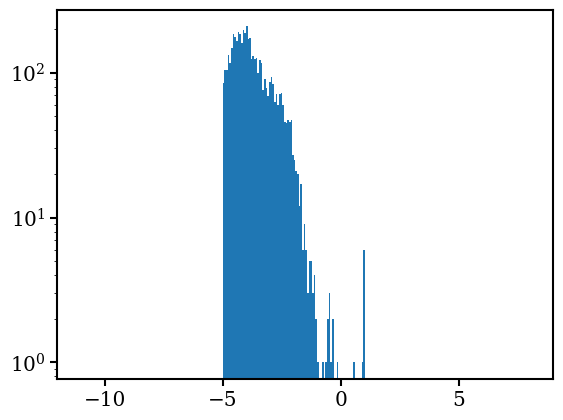

In [237]:
plt.hist( np.log10(temp["Z_APERTURE_COG_CHI2"]),bins=100,range=(-5,2) )
plt.yscale("log")
plt.show()

In [239]:
temp[ temp["Z_APERTURE_COG_CHI2"] > 2 ]["FILE_PATH"]

/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-160p060-170p065/1679p622/SGA_tgid_39633413359011203
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-130p030-140p035/1335p345/SGA_tgid_39632970251766642
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-200p040-210p045/2092p417/SGA_tgid_39633109322303901


In [229]:

hdus = fits.open("/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39632990178904830_ra_139.787_dec_35.605.fits")

gimg = hdus[0].data[0]
rimg = hdus[0].data[1]
zimg = hdus[0].data[2]



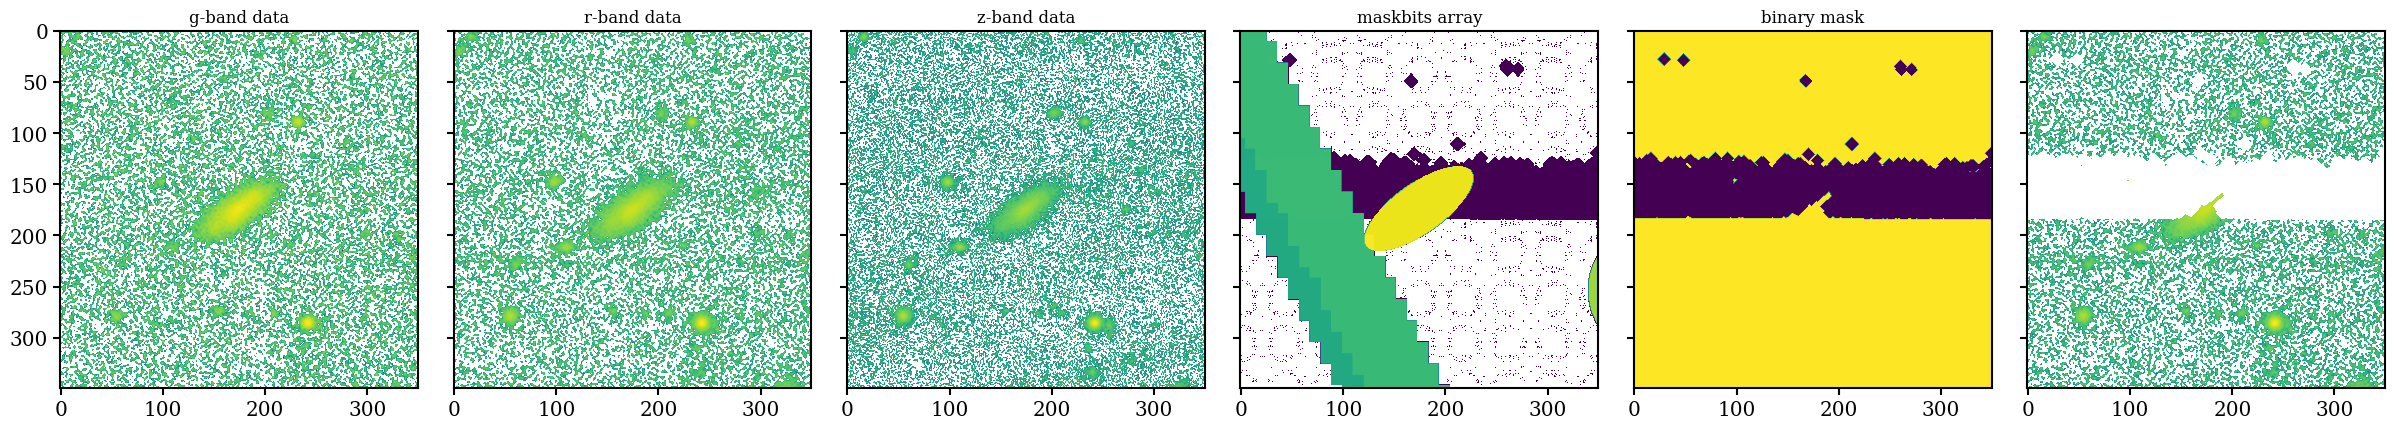

In [226]:
fig,ax = plt.subplots(1,6,figsize = (30,5),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1)
ax[0].set_title("g-band data")
ax[0].imshow(gimg,norm=LogNorm())

ax[1].set_title("r-band data")
ax[1].imshow(rimg,norm=LogNorm())

ax[2].set_title("z-band data")
ax[2].imshow(zimg,norm=LogNorm())

ax[3].set_title("maskbits array")
ax[3].imshow(hdus[2].data,norm=LogNorm() )

def get_binary_mask(mask_data_array):
    '''
    Input is the mask bit array
    '''

    maskclean = np.ones_like(mask_data_array, dtype=bool)
    set_maskbits = [2, 3, 4]         
    for bit in set_maskbits:
        maskclean &= (mask_data_array & 2**bit)==0
    
    maskclean = maskclean.astype(mask_data_array.dtype)

    return maskclean.astype(bool)

bin_mask = get_binary_mask(hdus[2].data)


ax[4].set_title("binary mask")
ax[4].imshow(bin_mask)


new_data = np.copy(rimg)
new_data[~bin_mask] = np.nan

ax[5].imshow(new_data,norm=LogNorm())

plt.show()

In [ ]:
, 
https://www.legacysurvey.org/viewer-dev/cutout.fits?ra=139.7869&dec=35.6055&size=350&layer=ls-dr9&pixscale=0.262&bands=grz&invvar&maskbits




0.020406885758998437

Notes:


The catastrophic error rate appears to be around ~2% which is okay I guess, I need to include a flag on when a COG fit is not
very good

/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-010p030-020p035/0124p317/SGA_tgid_39628514688765577 -> my method is good


/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-120p010-130p015/1223p145/SGA_tgid_39628133694969288 -> too many pixels are being masked by the stars


/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-160p060-170p065/1659p620/SGA_tgid_39633410502690735 -> bad image 


Notes:


The catastrophic error rate appears to be around ~2% which is okay I guess, I need to include a flag on when a COG fit is not
very good

1) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-130p045-140p050/1320p472/SGA_tgid_39633203455069052 -> this has some faulty, saturated pixels that are not being masked and hence the discrepant magnitude!

2) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-120p055-130p060/1269p552/SGA_tgid_39633324834032193 -> this is a satellite galaxy right next to its apparent large parent galaxy and SGA handles this better while we things its one whole galaxy

3) It seems that sometimes some of the edges of the stars that have saturated pixels are still not being masked. Have asked Dustin and John if there a standard good way to do this?
example: /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-210p030-220p035/2174p310/SGA_tgid_39628502122629022

9) 
5) /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-220m010-230m005/2251m075/SGA_tgid_39627607695691975 -> this is an example of a dwarf galaxy in the halo of a large elliptical galaxy so difficult ...


6) One thing to do is to not update the photometry if FRACFLUX > 0.2 etc. is not satisfied ...
example: /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-230p010-240p015/2377p117/SGA_tgid_39628070813963944


7) This appears to be an example of a object where my method is working correctly:
 /pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-230p010-240p015/2374p125/SGA_tgid_39628088539091024





In [ ]:
https://www.legacysurvey.org/viewer-dev/cutout.fits?ra=180.684&dec=62.500&size=1400&layer=ls-dr9&pixscale=0.262&invvar&maskbits



In [ ]:
# hdus = fits.open("/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39633203455069052_ra_132.070_dec_47.309.fits")
hdus = fits.open("/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39632971048684519_ra_191.104_dec_34.376.fits")




In [ ]:

gimg = hdus[0].data[0]
rimg = hdus[0].data[1]
zimg = hdus[0].data[2]


In [ ]:
fig,ax = plt.subplots(1,5,figsize = (25,5))

ax[0].set_title("g-band data")
ax[0].imshow(gimg,norm=LogNorm())

ax[1].set_title("r-band data")
ax[1].imshow(rimg,norm=LogNorm())

ax[2].set_title("z-band data")
ax[2].imshow(zimg,norm=LogNorm())

# ax[3].set_title("maskbits array")
# ax[3].imshow(hdus[2].data)

def get_binary_mask(mask_data_array):
    '''
    Input is the mask bit array
    '''

    maskclean = np.ones_like(mask_data_array, dtype=bool)
    set_maskbits = [2, 3, 4]         
    for bit in set_maskbits:
        maskclean &= (mask_data_array & 2**bit)==0
    
    maskclean = maskclean.astype(mask_data_array.dtype)

    return maskclean.astype(bool)

bin_mask = get_binary_mask(hdus[2].data)


ax[3].set_title("binary mask")
ax[3].imshow(bin_mask)


new_data = np.copy(rimg)
new_data[~bin_mask] = np.nan

ax[4].imshow(new_data,norm=LogNorm())
plt.show()

Make a slice plot focusing on the patch where DESI is really complete and do something there!

In [109]:
tot_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_combine_catalog.fits")

tot_cat["comov_dist"] = Planck18.comoving_distance(tot_cat["Z"]).data


In [110]:
tot_cat[tot_cat["TARGETID"] == 39627637408138942]

TARGETID,SURVEY,PROGRAM,HEALPIX,TILEID_LIST,RA,DEC,Z,ZWARN,DELTACHI2,SPECTYPE,Z_RR,TSNR2_QSO,TSNR2_LYA,PHOTSYS,LS_ID,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,EBV,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,MAG_G_DR9,MAG_R_DR9,MAG_Z_DR9,MAG_W1,MAG_W2,MAG_G_ERR_DR9,MAG_R_ERR_DR9,MAG_Z_ERR_DR9,MAG_W1_ERR,MAG_W2_ERR,OBJID,BRICKNAME,SIGMA_G,FRACFLUX_G,RCHISQ_G,SIGMA_GOOD_G,SIGMA_R,FRACFLUX_R,RCHISQ_R,SIGMA_GOOD_R,SIGMA_Z,FRACFLUX_Z,RCHISQ_Z,SIGMA_GOOD_Z,SHAPE_R,SHAPE_R_ERR,MU_R,MU_R_ERR,SERSIC,SERSIC_IVAR,BA,TYPE,PHI,FIBERMAG_R,MASKBITS,LOGM_SAGA_DR9,LOGM_M24_DR9,SWEEP,is_south,STARFDIST,STARDIST_DEG,STARMAG,STAR_RADIUS_ARCSEC,STAR_RA,STAR_DEC,SAMPLE,SGA_ID_MATCH,SGA_D26_NORM_DIST,SGA_DIST_DEG,IMAGE_PATH,FILE_PATH,MAG_G_APERTURE_COG,MAG_R_APERTURE_COG,MAG_Z_APERTURE_COG,MAG_G_APERTURE_COG_ERR,MAG_R_APERTURE_COG_ERR,MAG_Z_APERTURE_COG_ERR,MAG_G_APERTURE_COG_PARAMS,MAG_R_APERTURE_COG_PARAMS,MAG_Z_APERTURE_COG_PARAMS,MAG_G_APERTURE_COG_PARAMS_ERR,MAG_R_APERTURE_COG_PARAMS_ERR,MAG_Z_APERTURE_COG_PARAMS_ERR,LOGM_SAGA_APERTURE_COG,PCNN_FRAGMENT,NEAREST_STAR_NORM_DIST,MAG_G_APERTURE_R4,MAG_R_APERTURE_R4,MAG_Z_APERTURE_R4,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_Z,MAG_Z_ERR,LOGM_SAGA,HALPHA_FLUX,HALPHA_FLUX_IVAR,SNR_B,SNR_R,SNR_Z,HALPHA_EW,HALPHA_EW_IVAR,comov_dist
int64,bytes7,bytes6,int32,bytes47,float64,float64,float64,int64,float64,bytes6,float64,float32,float32,bytes1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,float32,float32,int16,float64,float64,bytes29,int64,float32,float32,float32,float32,float32,float32,bytes10,int64,float64,float64,bytes128,bytes128,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64
39627637408138942,main,bright,25726,20109,207.21450773772943,-6.340723622820521,0.005487411836892435,0,2243.392122785095,GALAXY,0.005487411836892435,5.0310535,10.370938,S,9906619115374270,2.017955,2.4951172,2.7416222,2.1916244,2.6378314,2.8283012,89.86588,108.16226,115.972336,11.240108,1.080005,-230.63063,-2358.337,25.88593,10.790425,2.4650958,0.8269985,0.21307078,0.00057659356,1.17257405e-05,0.027906774,0.9207577,0.9458971,0.969353,0.9952818,0.99709976,0.99938077,0.9997661,17.616013,17.41481,17.339115,19.873074,22.416435,0.0023774032,0.0030593877,0.005969779,0.10634247,2.1804285,1726,2072m062,457.22156,0.055191368,1.2557287,457.22156,355.29987,0.050945416,1.1283696,355.29987,182.0838,0.05059647,0.9890224,182.0838,7.123116,0.010246198,23.67361,0.0043717395,0.8792056,54376.46,0.443503,SER,-72.88433,21.507273,0,7.282344326041556,7.47202878229566,sweep-200m010-210m005-pz.fits,1,99.0,99.0,99.0,99.0,99.0,99.0,BGS_BRIGHT,999999,inf,0.07425737113237417,/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/image_tgid_39627637408138942_ra_207.214508_dec_-6.340724.fits,/pscratch/sd/v/virajvm/redo_photometry_plots/all_good/south/sweep-200m010-210m005/2072m062/BGS_BRIGHT_tgid_39627637408138942,--,--,--,--,--,--,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,-- .. --,--,--,--,--,--,--,17.616012573242188,0.002377403201535344,17.414810180664062,0.0030593876726925373,17.339115142822266,0.005969779100269079,7.282344326041556,1

In [124]:
def get_subset_five(tot_cat,rmag_min=19,rmag_max = 20):
    rmag_mask = (tot_cat["MAG_R"] > rmag_min) & (tot_cat["MAG_R"] < rmag_max) & (tot_cat["Z"] < 0.05)

    tot_cat_i = tot_cat[rmag_mask]

    rnd_inds = np.random.randint(len(tot_cat_i),size = 7)

    print_radecs(tot_cat_i[rnd_inds],ra="RA",dec="DEC")
    
    return 


In [133]:
get_subset_five(tot_cat,rmag_min=19,rmag_max=20)

28.06309505876784 -3.085407609196813
136.46771143216816 40.88944511396727
204.54860480526395 -1.4337963941972693
226.76201616824486 3.0962915431565863
115.41989494682188 21.51129013659991
151.05570017626374 0.561472052062706
197.68943948727517 52.61625849962994


In [ ]:
Planck18.luminosity_distance(0.005)

In [ ]:
# temp = tot_cat[(tot_cat["LOGM_SAGA"] < 7.25) & (tot_cat["LOGM_SAGA"] > 6.75) & (tot_cat["Z"] < 0.005)]
temp = tot_cat[(tot_cat["LOGM_SAGA"] < 7.25) & (tot_cat["LOGM_SAGA"] > 6.75) & (tot_cat["Z"] < 0.005)]


In [ ]:
print_radecs(temp,ra="RA",dec="DEC")

In [ ]:
save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs"
lowz_cat = Table.read(save_folder + "/iron_lowz_dark_all_phot_final_fixed.fits")

In [ ]:
# lowz_cat

In [ ]:
# zpix = Table.read("/global/cfs/cdirs/desi/spectro/redux/guadalupe/zcatalog/v0/zall-pix-guadalupe.fits")
zpix = Table.read("/global/cfs/cdirs/desi/spectro/redux/iron/zcatalog/v1/zall-pix-iron.fits")


In [ ]:
# 

In [ ]:
lowz_main_mask = (zpix["SCND_TARGET"] == 2**15) | (zpix["SCND_TARGET"] == 2**16) | (zpix["SCND_TARGET"] == 2**17)



In [ ]:
lowz_sv_mask = np.zeros(len(zpix)).astype(bool)

for svi in range(1,4):
    svi_mask = (zpix[f"SV{svi}_SCND_TARGET"] == 2**15) | (zpix[f"SV{svi}_SCND_TARGET"] == 2**16) | (zpix[f"SV{svi}_SCND_TARGET"] == 2**17)
    lowz_sv_mask |= svi_mask

    
    

In [ ]:
## and then we choose SCND_ANY target?? Will this include the LOWZ targets??

In [ ]:
np.sum(lowz_main_mask),np.sum(lowz_sv_mask)

In [ ]:
## does survey=special mean that??? -> yes
#  Tertiary targets are similar to secondary targets,
# but they are observed on dedicated special survey tiles instead of being interleaved
# with regular targets on normal tiles.

#we want to combine any secondary target and also special targets!!

In [ ]:
# zpix[(zpix["SURVEY"] == "special")  & (zpix["COADD_FIBERSTATUS"] == 0)]

In [ ]:
# zpix[ (zpix["SV3_SCND_TARGET"] == 2**15) & (zpix["DELTACHI2"] < 20) ]["TARGET_RA","TARGET_DEC","Z","DELTACHI2"]

In [ ]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_bright_filter_zsucc_zrr02_allfracflux_V2.fits")





In [ ]:
np.unique(temp["SURVEY"])

In [ ]:
from desitarget import targetmask
desi_mask = targetmask.desi_mask
desi_tgt = zpix["DESI_TARGET"]
is_scnd = (desi_tgt & desi_mask['SCND_ANY'] != 0)

In [ ]:
len(zpix)

In [ ]:
zpix[is_scnd]

In [ ]:
siena_cat = Table.read("/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits")
print(len(siena_cat))

In [ ]:
bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_bright_filter_zsucc_zrr02_allfracflux_W_SGA.fits")
bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_faint_filter_zsucc_zrr03_allfracflux_W_SGA.fits")
elg_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_elg_filter_zsucc_zrr05_allfracflux_W_SGA.fits")

print(len(bgsb_cat), len(bgsf_cat), len(elg_cat))

In [ ]:
desi_sga_cat = vstack([bgsb_cat, bgsf_cat, elg_cat])
# desi_sga_cat = desi_sga_cat[ desi_sga_cat["Z"] > 0.001 ]
print(len(desi_sga_cat))


In [ ]:
# print_radecs(desi_sga_cat, ra="RA",dec="DEC")

In [ ]:

##what ever SGA sources do not have redshifts, we will automatically assume it is not of interest to us!!
##to be the same as when we finally clean the objects, we remove objects with SGA_D26 < 2.
##we then make decisions on the remaining objects!

idx,d2d,_=match_c_to_catalog(c_cat = desi_sga_cat, catalog_cat = siena_cat)
siena_matched = siena_cat[idx]
print(len(siena_matched))


#the semi-major axis is needed in arcsec and so not muptipled by 60 here
all_norm_dist = calc_normalized_dist(desi_sga_cat["RA"].data,desi_sga_cat["DEC"].data, 
                                         siena_matched["RA_MOMENT"].data, siena_matched["DEC_MOMENT"].data,
                                         siena_matched["SMA_SB26"].data, cen_ba=siena_matched["BA"].data, 
                                         cen_phi=siena_matched["PA"].data, multiplier=2)

print(len(all_norm_dist))


#remove objects that do not have a SGA redshift and all_norm_dist < 1
remove_mask = ( siena_matched["Z_LEDA"] < 0) & (all_norm_dist < 1)
#we also need good photometry for the object
good_photo_mask =  (siena_matched["G_COG_PARAMS_MTOT"] > 0) & (siena_matched["R_COG_PARAMS_MTOT"] > 0) 
#we also want to make sure the SGA galaxy we have matched to does have a redshift
has_redshift = (siena_matched["Z_LEDA"] > 0)
final_mask = ~remove_mask & good_photo_mask & has_redshift
desi_sga_cat = desi_sga_cat[final_mask]
siena_matched_f = siena_matched[ final_mask ]

print(len(desi_sga_cat))

##then we remove objects that are not dwarfs
##measure stellar mass using COG values
from desi_lowz_funcs import get_stellar_mass

siena_matched_f["g-r"] = siena_matched_f["G_COG_PARAMS_MTOT"] - siena_matched_f["R_COG_PARAMS_MTOT"]
siena_matched_f["LOGM_SAGA"] = get_stellar_mass(np.array(siena_matched_f["g-r"]), np.array(siena_matched_f["R_COG_PARAMS_MTOT"]), np.array(siena_matched_f["Z_LEDA"]) )

print(len(desi_sga_cat), len(siena_matched_f)  )

dwarf_mask = (siena_matched_f["LOGM_SAGA"] < 9.25)

#remove objects in desi that are not dwarfs
desi_sga_cat_dw = desi_sga_cat[dwarf_mask]
siena_matched_dw = siena_matched_f[dwarf_mask]

# Apply same mask to both arrays
desi_sga_cat_dw = desi_sga_cat[final_mask][dwarf_mask]
siena_matched_dw = siena_matched_f[dwarf_mask]


desi_sga_cat_dw["LOGM_SAGA_SIENA"] = siena_matched_dw["LOGM_SAGA"]
desi_sga_cat_dw["Z_LEDA"] = siena_matched_dw["Z_LEDA"]
desi_sga_cat_dw["RA_LEDA"] = siena_matched_dw["RA_LEDA"]
desi_sga_cat_dw["DEC_LEDA"] = siena_matched_dw["DEC_LEDA"]
desi_sga_cat_dw["R_COG_PARAMS_MTOT"] = siena_matched_dw["R_COG_PARAMS_MTOT"]
desi_sga_cat_dw["G_COG_PARAMS_MTOT"] = siena_matched_dw["G_COG_PARAMS_MTOT"]


print(len(desi_sga_cat_dw )  )



In [ ]:
print_radecs(desi_sga_cat_dw[:10], ra="RA",dec="DEC")


In [ ]:
desi_sga_cat_dw[:10]["RA","DEC","Z","TARGETID","LOGM_SAGA","LOGM_SAGA_SIENA","MAG_R","MAG_G","R_COG_PARAMS_MTOT","G_COG_PARAMS_MTOT"]

In [ ]:
from desi_lowz_funcs import get_stellar_mass

In [ ]:
from desi_lowz_funcs import get_stellar_mass
import numpy as np
from astropy.table import Table, hstack

In [ ]:
# Step 1: Match SGA to Siena catalog
idx, d2d, _ = match_c_to_catalog(c_cat=desi_sga_cat, catalog_cat=siena_cat)
siena_matched = siena_cat[idx]
print("Total matched:", len(siena_matched))

#adding the DESI redshift to the SGA redshift 
siena_matched["Z_DESI"] = desi_sga_cat["Z"]

# Step 2: Compute normalized distances (no unit conversion needed)
all_norm_dist = calc_normalized_dist(
    desi_sga_cat["RA"].data,
    desi_sga_cat["DEC"].data,
    siena_matched["RA_MOMENT"].data,
    siena_matched["DEC_MOMENT"].data,
    siena_matched["SMA_SB26"].data,
    cen_ba=siena_matched["BA"].data,
    cen_phi=siena_matched["PA"].data,
    multiplier=2,
)
print("All normalized distances:", len(all_norm_dist))

# Step 3: Build masks

#if not a Z_LEDA redshift, we should use the desi redshift
# has_redshift = siena_matched["Z_LEDA"] > 0

good_photo_mask = (
    (siena_matched["G_COG_PARAMS_MTOT"] > 0) &
    (siena_matched["R_COG_PARAMS_MTOT"] > 0)
)

inside_galaxy_mask = (all_norm_dist <= 1)
final_mask =  good_photo_mask & inside_galaxy_mask #has_redshift &

# Step 4: Apply final mask to both catalogs
desi_matched_clean = desi_sga_cat[final_mask]
siena_matched_clean = siena_matched[final_mask]
print("After redshift & photo & dist cuts:", len(desi_matched_clean))

relevant_id = np.where( desi_matched_clean["TARGETID"] == 39627876131147532 )[0]
print(relevant_id)

# Step 5: Compute stellar mass and color
gmag = siena_matched_clean["G_COG_PARAMS_MTOT"].data
rmag = siena_matched_clean["R_COG_PARAMS_MTOT"].data
zleda = siena_matched_clean["Z_DESI"].data
g_r = gmag - rmag

print(gmag[relevant_id], rmag[relevant_id], zleda[relevant_id], g_r[relevant_id])

logm = get_stellar_mass(np.array(g_r), np.array(rmag), np.array(zleda))
siena_matched_clean["g-r"] = g_r
siena_matched_clean["LOGM_SAGA"] = logm

# Step 6: Apply dwarf cut
dwarf_mask = siena_matched_clean["LOGM_SAGA"] < 9.25
desi_dwarfs = desi_matched_clean[dwarf_mask]
siena_dwarfs = siena_matched_clean[dwarf_mask]
print("Final dwarf sample:", len(desi_dwarfs))

# Step 7: Combine into a final catalog with propagated columns
final_cat = desi_dwarfs.copy()
final_cat["LOGM_SAGA_SIENA"] = siena_dwarfs["LOGM_SAGA"]
final_cat["Z_LEDA"] = siena_dwarfs["Z_LEDA"]
final_cat["RA_LEDA"] = siena_dwarfs["RA_LEDA"]
final_cat["DEC_LEDA"] = siena_dwarfs["DEC_LEDA"]
final_cat["R_COG_PARAMS_MTOT"] = siena_dwarfs["R_COG_PARAMS_MTOT"]
final_cat["G_COG_PARAMS_MTOT"] = siena_dwarfs["G_COG_PARAMS_MTOT"]
final_cat["g-r_siena"] = siena_dwarfs["g-r"]

#take all the candidate dwarfs, and pass it to my pipeline
#check if there is roughly consistent photometry ..., it not, we will acknowledge as more work needed in the paper!



In [ ]:
final_cat[:30]["RA","DEC","LOGM_SAGA","LOGM_SAGA_SIENA","MAG_R","MAG_G","R_COG_PARAMS_MTOT","G_COG_PARAMS_MTOT","g-r_siena","Z","Z_LEDA"]

In [ ]:
## how to get the flow velocity???

import requests
import json

def DVcalculator_list(alpha_lst, delta_lst, system='supergalactic', 
                      parameter='distance', values=[20], calculator='NAM'):
    
    """
    Inputs: 
        alpha: [array] (float) [deg]
            first coordinate parameter  (RA,  Glon, SGL)
        delta: [array] (float) [deg]
            second coordinate parameter (Dec, Glat, SGB)  
        system: (string)
            coordinate system: 
            Options are:
                "equatorial"
                "galactic"
                "supergalactic"
        parameter: (string)
            the quantity whose value is provided
            Options are:
                "distance"
                "velocity"
        value: [array] (float)
            the value of the input quantity
            distance in [Mpc] and velocity in [km/s]
            
        calculator: desired Cosmicflows caluclator
            Options are:
                "NAM" to query the calculator at http://edd.ifa.hawaii.edu/NAMcalculator
                "CF3" to query the calculator at http://edd.ifa.hawaii.edu/CF3calculator
                "CF4" to query the calculator at http://edd.ifa.hawaii.edu/CF3calculator
        
    Output:
        A python dictionary which contains the distance and velocity of the 
        given object and the coordinate of the object in different systems

    """
    
    if len(alpha_lst)!=len(delta_lst) or len(delta_lst)!=len(values):
        return {"message": "Inconsistent sizes of the input arrays !"}
    
    payload = {}
    payload["galaxies"] = []
    
    for i in range(len(alpha_lst)):
        
        coordinate = [float(alpha_lst[i]), float(delta_lst[i])]
        galDict  = {
                  'coordinate': coordinate,
                  'system': system,
                  'parameter': parameter,
                  'value': float(values[i])
                 }
        
        payload["galaxies"].append(galDict)
    
    
    headers = {'Content-type': 'application/json'}
    
    API_url = 'http://edd.ifa.hawaii.edu/'+calculator+'calculator/api.php'
    
    try:
        r = requests.get(API_url, data=json.dumps(payload), headers=headers)
        output = json.loads(r.text) # a python dictionary
    except:
        print("Something went wrong!")  
        print("Please check your intput parameters ...")
        output = None

    return output

In [ ]:
c_light = 3e5 #in km/s

nam_cutoff = 2850/c_light #in km/s
cf3_cutoff = 12000/c_light #in km/s

final_cat_nam = final_cat[(final_cat["Z"] <= nam_cutoff)]
final_cat_cf3 = final_cat[(final_cat["Z"] <= cf3_cutoff) & (final_cat["Z"] > nam_cutoff)]
final_cat_far = final_cat[(final_cat["Z"] > cf3_cutoff)]

#for velocities below 2850 km/s, we use NAM
#for velociities above that up to 200 Mpc/8000km/s, we use the linear model

print(len(final_cat_nam), len(final_cat_cf3) )
print(len(final_cat_far))

In [ ]:
final_cat_nam["Z"].data * c_light

In [ ]:

bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_bright_filter_zsucc_zrr02_allfracflux_W_SGA.fits")
bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_faint_filter_zsucc_zrr03_allfracflux_W_SGA.fits")

bgsb_cat["SAMPLE_DESI"] = ["BGS_BRIGHT"] * len(bgsb_cat)
bgsf_cat["SAMPLE_DESI"] = ["BGS_FAINT"] * len(bgsf_cat)
    
print("Number of sources overlapping with SGA pixels: ", len(bgsb_cat), len(bgsf_cat))
print("Note that all of these are not dwarf galaxies!")

desi_sga_cat = vstack([bgsb_cat, bgsf_cat])

desi_sga_dwarfs = process_sga_matches(desi_sga_cat)


In [ ]:
from desi_lowz_funcs import save_table

In [ ]:
save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs"

save_table(desi_sga_dwarfs, save_folder + "/iron_sga_matched_dwarfs.fits",comment = "")

In [ ]:
# desi_sga_dwarfs["SAMPLE_DESI"]

In [ ]:
dwarf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_sga_matched_dwarfs.fits")


In [ ]:
fits.open("/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga_cutouts/image_tgid_39627854270434442_ra_185.167997_dec_2.758206.fits")[2].header
          

In [ ]:
masked_rows = dwarf_cat['IMAGE_PATH'].mask  # Boolean array
print(np.where(masked_rows))  # Indices of masked entries

# Or just see how many are masked
print(np.sum(masked_rows), "entries are masked")

In [ ]:
dwarf_cat[masked_rows]["IMAGE_PATH"]

In [ ]:
plt.figure(figsize =(5,5))
plt.scatter(Planck18.luminosity_distance(desi_sga_dwarfs["Z"].data).value, desi_sga_dwarfs["DIST_MPC"],color = "grey",s=25)

plt.xlim([0,40])
plt.ylim([0,40])
plt.plot([0,40],[5,45],color = "k",ls = "--",alpha = 0.5)
plt.plot([0,40],[-5,35],color = "k",ls = "--",alpha = 0.5)
plt.plot([0,40],[0,40],color = "k",lw = 1)
plt.show()

In [ ]:
plt.figure(figsize =(5,5))
plt.hist2d(desi_sga_dwarfs["DIST_MPC"], desi_sga_dwarfs["SGA_LOGM_SAGA"],bins=20,range=((0,40), (6,9.5) ))
plt.xlim([0,40])
plt.ylim([6,9.5])
plt.show()

In [ ]:
# okay given a object, can I get all the DESI spectra that lie close to it at the same redshift???

len(np.unique(desi_sga_dwarfs["SGA_ID"].data))

In [ ]:
len(desi_sga_dwarfs)

In [ ]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")

In [ ]:
fits.open(temp["IMAGE_PATH"][0])

In [ ]:
def get_sv_bgs_mask(catalog, bgs_class = "BGS_BRIGHT"):
    '''
    Get the mask to select for SV objects

    all_sv_desi_tgt is a dictionary/table storing the target classes for each SV class
    '''
    
    #then specifically BGS BRIGHT
    sv1_class_mask = (catalog["SV1_BGS_TARGET"] & sv1_targetmask.bgs_mask[bgs_class] != 0)
    sv2_class_mask = (catalog["SV2_BGS_TARGET"] & sv2_targetmask.bgs_mask[bgs_class] != 0)
    sv3_class_mask = (catalog["SV3_BGS_TARGET"] & sv3_targetmask.bgs_mask[bgs_class] != 0)

    
    return (sv1_class_mask) | (sv2_class_mask) | (sv3_class_mask)

In [ ]:
sv_bgsb = get_sv_bgs_mask_v2(zpix, bgs_class = "BGS_BRIGHT")
sv_bgsf = get_sv_bgs_mask_v2(zpix, bgs_class = "BGS_FAINT")


In [ ]:
len(zpix[ sv_bgsb | sv_bgsf ])

In [ ]:
all_elg_data = Table.read( "/pscratch/sd/v/virajvm/catalog/all_elg_healpix_catalogs.fits")


In [ ]:
all_elg_data

In [ ]:
# lowz_tab[lowz_tab["LOGM_SAGA"] < 9.25]

In [ ]:

plt.hist2d(lowz_tab["LOGM_SAGA"],np.log10(lowz_tab["MASS_CG"]),bins=100,
           range= ( (6,10),(6,10) ),norm=LogNorm())
plt.xlim([6,10])
plt.ylim([6,10])
plt.plot([6,10],[6,10],color = "k")
plt.show()

Print some summary numbers of the catalog

In [ ]:
bins = [-10,6,7,8,9.25]
samples = ["BGS_BRIGHT","BGS_FAINT","LOWZ","ELG"]

for si in samples:
    temp = tot_cat[tot_cat["SAMPLE"] == si]
    for i in range(len(bins) - 1):
        mi_low = bins[i]
        mi_high = bins[i+1]
        temp_ii = temp[ (temp["LOGM_SAGA"] > mi_low) & (temp["LOGM_SAGA"] < mi_high) ]
        
        print(f"Number of galaxies in {si} between {mi_low:.1f} and {mi_high:.1f} = {len(temp_ii)}")

    print("---"*10)

#

samples = ["BGS_BRIGHT","BGS_FAINT","LOWZ","ELG"]

for si in samples:
    temp = tot_cat[tot_cat["SAMPLE"] == si]
    mi_low = -10
    mi_high = 9.25
    
    temp_ii = temp[ (temp["LOGM_SAGA"] > mi_low) & (temp["LOGM_SAGA"] < mi_high) ]
    
    print(f"TOTAL Number of galaxies in {si} between {mi_low:.1f} and {mi_high:.1f} = {len(temp_ii)}")

    print("---"*10)

Select some TGIDS whose spectra to display at different redshifts

BGSB =  39627322709513192
BGSF = 39627345413284126
LOWZ = 2705974209019904
ELG = 39627357518039557


In [ ]:
rmag_bins = np.arange(18,24,1)

rmag_bins

In [ ]:

for i in range(1,2):
    rmag_min = rmag_bins[i]
    rmag_max = rmag_bins[i+1]
    
    zred_mask = (tot_cat["LOGM_SAGA"] < 7.6) & (tot_cat["LOGM_SAGA"] > 7.4) & (tot_cat["MAG_R"] > rmag_min) & (tot_cat["MAG_R"] < rmag_max) & (tot_cat["SAMPLE"] == "BGS_FAINT")

    temp = tot_cat[zred_mask]
    for i in range(10):
        print(f"https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid{temp['TARGETID'][i]}")
    
    print("----")
    
# # bgsf_zred_mask = (tot_cat["LOGM_SAGA"] < 7.6) & (tot_cat["LOGM_SAGA"] > 7.4) & (tot_cat["SAMPLE"] == "BGS_FAINT") 
# # lowz_zred_mask = (tot_cat["LOGM_SAGA"] < 7.6) & (tot_cat["LOGM_SAGA"] > 7.4) & (tot_cat["SAMPLE"] == "LOWZ") 
# # elg_zred_mask = (tot_cat["LOGM_SAGA"] < 7.6) & (tot_cat["LOGM_SAGA"] > 7.4) & (tot_cat["SAMPLE"] == "ELG") 


In [ ]:
eg_tgids = [39627427021851828, 39627491345697115, 2705980336898048, 39627555304643301, 39627391634506945]

In [ ]:
sample_color_map = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

def make_spectra_panel(tgids_interest, tot_cat,wave_min=3400, wave_max = 9800, save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/example_spec/"):
    
    fig, ax = plt.subplots(len(tgids_interest), 1, figsize=(15, int(3*len(tgids_interest)) ),sharex=True)
    plt.subplots_adjust(hspace = 0.1)

    for i in range(len(tgids_interest)):
    
        result = np.load(save_folder + f"spec_{tgids_interest[i]}.npz")
        
        fluxs = result["flux"]
        waves = result["wave"]
        ivar = result["ivar"]
        rgb_img = result["image"]
        mag_r = result["mag_r"]
        dchi2 = result["dchi2"]
        tgid = result["tgid"]
        zred = result["zred"]

        samp_i = tot_cat[tot_cat["TARGETID"] == tgid]["SAMPLE"][0]

        waves = waves/(1+zred)
        
        # Main spectrum plotting
        ax[i].plot(waves, fluxs, color='grey', alpha=0.15, lw=1)

        flux_smooth = convolve(fluxs, Gaussian1DKernel(5))[5:-5]

        ax[i].plot(waves[5:-5], flux_smooth , color=sample_color_map[samp_i], lw=2)
        
        ax[i].set_xlim([wave_min, wave_max])
        ax[i].tick_params(axis='both', labelsize=17)
        ax[i].set_ylim([-0.5, np.max(flux_smooth) * 1.3])
        tick_vals = np.linspace(-0.5, np.max(flux_smooth) * 1.125, 3).astype(int)
        ax[i].set_yticks(tick_vals)

        if i == len(tgids_interest) - 1:
            ax[i].set_xlabel('Rest-Frame Wavelength [$\\AA$]', fontsize=17)
            
        # ax[i].set_ylabel('$F_{\\lambda}$ [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]', fontsize=15)
        # ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
        # Add inset axes in top-right
        inset_ax = inset_axes(ax[i], width=1.5, height=1.5, 
                        bbox_to_anchor=(0.85, 0.15, 0.4, 0.4),  # (x0, y0, width, height) in axes fraction
                      bbox_transform=ax[i].transAxes,
                      loc='lower left')  # position inside the bbox
        
        cut = 5
        inset_ax.imshow(rgb_img[cut:-cut,cut:-cut,:],origin="lower")
        inset_ax.set_title(f"{tgid}",fontsize = 11)
        inset_ax.axis('off')  # Hide axis ticks and frame
        # inset_ax.text(0.5, 0.95,"(%.3f,%.3f, z=%.3f)"%(temp["RA"][0],temp["DEC"][0], temp["Z"][0]) ,color = "white",fontsize = 9.25,
        #                   transform=inset_ax.transAxes, ha = "center", verticalalignment='top')

        inset_ax.text(0.5, 0.95,"z=%.3f"%(zred) ,color = "white",fontsize = 18,
                          transform=inset_ax.transAxes, ha = "center", verticalalignment='top')
        
        inset_ax.text(0.5, 0.18,"$\Delta\chi^2$=%.0f"%(dchi2) ,color = "white",fontsize = 12,
                          transform=inset_ax.transAxes, ha = "center", verticalalignment='top')

        ax[i].text(0.65,0.9, r"r-band mag = %.1f"%(mag_r), fontsize = 17.5,
                  transform=ax[i].transAxes, ha = "center", verticalalignment='top')

    ##lines to include are Halpha, OIII, Hbeta, SII, 

    # Spectral lines: [wavelength in Å, label]
    lines = [(6563, r'H$\alpha$'), (4959, ''), (5007, ''), (4861, ''), (4340.471, r"H$\gamma$"), (3727, r"[OII]"), 
            (6716.440,''),(6730.810,  r"[SII]")]

    ymax = 12.75
    stub_height = 1 # height of the vertical stub
    label_offset = 0.5  # space between stub and label
    
    for wl, label in lines:
        ax[0].plot([wl, wl], [ymax, ymax + stub_height], color='k', lw=1)  # short stub
        ax[0].text(wl, ymax + stub_height + label_offset, label,
                ha='center', va='bottom', fontsize=11, color='k')

    ax[0].text(4840, ymax + stub_height + label_offset, r"H$\beta$",
                ha='center', va='bottom', fontsize=11, color='k')

    ax[0].text(5020, ymax + stub_height + label_offset, r'[OIII]',
                ha='center', va='bottom', fontsize=11, color='k')

    ax[0].set_title(r"M$_{\star} \sim 10^{7.5} M_{\odot}$ galaxies in DESI at $19 < r_{\rm mag} < 23$",fontsize =22)
    
    plt.savefig(f"/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/survey_dwarf_spectra.png",bbox_inches="tight",dpi=300)
    plt.show()

    

In [ ]:
make_spectra_panel(eg_tgids, tot_cat,wave_min=3550, wave_max = 9700, save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/example_spec/")


In [ ]:

dec_low = 0 - 5
dec_high = 0 + 5

slice_mask = (tot_cat["RA"] < 230) & (tot_cat["RA"] > 130) & (tot_cat["DEC"] > dec_low) & (tot_cat["DEC"] < dec_high) #& (tot_cat["Z"] < 0.2) 



gama_g12_mask = (tot_cat["RA"] < 186) & (tot_cat["RA"] > 174) & (tot_cat["DEC"] > -3) & (tot_cat["DEC"] < 2) & (tot_cat["Z"] < 0.2) & (tot_cat["MAG_R"] < 19.8)
gama_g09_mask = (tot_cat["RA"] < 141) & (tot_cat["RA"] > 129) & (tot_cat["DEC"] > -2) & (tot_cat["DEC"] < 3) & (tot_cat["Z"] < 0.2) & (tot_cat["MAG_R"] < 19.8)

gama_g15_mask = (tot_cat["RA"] < 223.5) & (tot_cat["RA"] > 211.5) & (tot_cat["DEC"] > -2) & (tot_cat["DEC"] < 3) & (tot_cat["Z"] < 0.2)   & (tot_cat["MAG_R"] < 19.8)

tot_cat_slice = tot_cat[slice_mask]

tot_cat_slice_sdss = tot_cat[slice_mask & (tot_cat["MAG_R"] < 17.7)]

tot_cat_slice_gama = tot_cat[  gama_g12_mask | gama_g15_mask | gama_g09_mask ]


In [ ]:
plt.figure(figsize = (10,2))
plt.scatter(tot_cat_slice_gama["RA"], tot_cat_slice_gama["DEC"],s=0.05)
plt.xlim([130,230])


In [ ]:

tot_cat_slice_sdss["comov_dist"] = Planck18.comoving_distance(tot_cat_slice_sdss["Z"]).data



In [ ]:
zmax = 0.3

zgrid = np.linspace(0.001,zmax,1000)

cmov_dist = Planck18.comoving_distance(zgrid)

from scipy.interpolate import UnivariateSpline

spl_z = UnivariateSpline( cmov_dist, zgrid, s=0.)

plt.figure(figsize = (4,4))
plt.plot(zgrid, cmov_dist)
plt.xlim([0,zmax])
plt.show()

In [ ]:
spl_z(500)

In [ ]:
from astropy.table import Table
saga_gals = Table.read('https://sagasurvey.org/data/saga-dr3-tableC2.txt', format='ascii.mrt')

print(len(saga_gals))

In [ ]:
saga_gals[ (saga_gals["z"] <  0.01) & (saga_gals["z"] != -1)]

In [ ]:
saga_slice_mask = (saga_gals["RAdeg"] < 230) & (saga_gals["RAdeg"] > 130) & (saga_gals["DEdeg"] < 5) & (saga_gals["DEdeg"] > -5) & (saga_gals["z"] != -1) & (saga_gals["z"] < 0.3) & (saga_gals["log(M*)"] < 9.25 )

saga_gals_slice = saga_gals[saga_slice_mask]

print(len(saga_gals_slice))

In [ ]:
130+230

In [ ]:
title_size = 19
ra_ticks_vals = np.array([130,150, 170, 190, 210, 230])
# ra_ticks_vals = np.array([200, 225, 250])
ra_min = 130
ra_max = 230
pad_val =-15

fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
### ALL GALAXIES IN NED-LVS
ra_radians = np.deg2rad(tot_cat_slice["RA"])
ax.scatter(ra_radians, tot_cat_slice["comov_dist"], color = "k", alpha=0.75,s=0.25,rasterized=True)
# Add labels and a colorbar
ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# Set title and labels
# ax.set_title('Galaxy Distribution by Redshift and RA')
ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
ax.set_thetamax(ra_max)
ax.set_rlim(0,600)
# ax.set_rticks([])
# ax.tick_params(which='both', length=10, labelsize )  # radial = 'y' in polar
# ax.set_rlim(0, 0.2)

# Add the label using ax.text()
ax.text(np.deg2rad(110),        # angle in radians
        ax.get_rmax() * 0.5,   # just outside the outermost circle
        "Comoving Distance [Mpc]",
        rotation=-38,
        ha='center',
        va='center',
        fontsize=12)

# ax.grid(ls = "-", color = "r",alpha = 1)
ax.grid(ls = ":", color = "lightgrey",alpha = 0.25)

ra_ticks = np.deg2rad(ra_ticks_vals)
ax.set_xticks(ra_ticks)

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_slice_plot.png",bbox_inches="tight",dpi=150)
plt.close()

###




In [ ]:
import cmasher as cmr


In [ ]:
# title_size = 19
# ra_ticks_vals = np.array([130,150, 170, 190, 210, 230])
# # ra_ticks_vals = np.array([200, 225, 250])
# ra_min = 130
# ra_max = 230
# pad_val =-15

# fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

# plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
# ### ALL GALAXIES IN NED-LVS
# ra_radians = np.deg2rad(tot_cat_slice["RA"])
# ax.scatter(ra_radians, tot_cat_slice["comov_dist"], c = tot_cat_slice["LOGM_SAGA"].data, alpha=0.75,s=0.25,rasterized=True, vmin=7,vmax = 9.25, cmap = cmr.ember)
# # Add labels and a colorbar
# ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
# ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# # Set title and labels
# # ax.set_title('Galaxy Distribution by Redshift and RA')
# ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
# ax.set_thetamax(ra_max)
# ax.set_rlim(0,600)

# # Add the label using ax.text()
# ax.text(np.deg2rad(110),        # angle in radians
#         ax.get_rmax() * 0.5,   # just outside the outermost circle
#         "Comoving Distance [Mpc]",
#         rotation=-38,
#         ha='center',
#         va='center',
#         fontsize=12)

# ax.grid(ls = ":", color = "lightgrey",alpha = 0.25)

# ra_ticks = np.deg2rad(ra_ticks_vals)
# ax.set_xticks(ra_ticks)

# # plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_slice_plot.png",bbox_inches="tight")
# plt.show()

# ###




In [ ]:
# Suppose your Astropy table is called `tab`
samples = tot_cat_slice["SAMPLE"].astype(str)  # Convert from bytes to string if necessary

sample_color_map = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }
sample_color_map.items()

In [ ]:
title_size = 19
ra_ticks_vals = np.array([130,150, 170, 190, 210, 230])
# ra_ticks_vals = np.array([200, 225, 250])
ra_min = 130
ra_max = 230
pad_val =-15

fig, ax = plt.subplots(4,1,figsize = (5,20),subplot_kw={'projection': 'polar'})
plt.subplots_adjust(wspace = 0.075, hspace = -0.6)

plot_ind = 0

# ax = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]  ]
ax = [ax[0], ax[1], ax[2], ax[3]  ]


for sample_name, color in sample_color_map.items():

    mask = samples == sample_name
    
    ra_radians = np.deg2rad(tot_cat_slice[mask]["RA"])

    # ax[plot_ind].set_title(sample_name,fontsize = 13)
    
    # ax[plot_ind].scatter(ra_radians, tot_cat_slice["comov_dist"][mask], alpha=0.75,s=0.1,rasterized=True, color = "k" )
    ax[plot_ind].scatter(ra_radians, tot_cat_slice["comov_dist"][mask], alpha=1,s=0.1,rasterized=True, color = color )
    

    # Add labels and a colorbar
    ax[plot_ind].set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
    ax[plot_ind].set_theta_direction(-1)       # Optional: clockwise direction for RA
    # Set title and labels
    # ax.set_title('Galaxy Distribution by Redshift and RA')
    ax[plot_ind].set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
    ax[plot_ind].set_thetamax(ra_max)
    ax[plot_ind].set_rlim(0,600)

    ax[plot_ind].set_yticks([])
    ax[plot_ind].set_xticks([])


    if "BGS_" in sample_name:
        sample_name = sample_name.replace("BGS_", "BGS ")

    ax[plot_ind].text(np.deg2rad(180),        # angle in radians
        ax[plot_ind].get_rmax() * 0.85,   # just outside the outermost circle
        sample_name,
        color = "k",
        rotation=0,
        ha='center',
        va='center',
        fontsize=18)

    # Set radial ticks (e.g., comoving distances)
    # r_ticks_vals = [100, 200, 300, 400, 500, 600]
    
    # ax[plot_ind].set_yticks(r_ticks_vals)           # positions of radial ticks
    # ax[plot_ind].set_yticklabels([])

    # ra_ticks = np.deg2rad(ra_ticks_vals)
    # ax[plot_ind].set_xticks(ra_ticks)
    

    plot_ind += 1

# plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_sample_slice_plot.png",dpi=150)
plt.close()
    

In [ ]:

fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
ra_radians = np.deg2rad(tot_cat_slice_sdss["RA"])
ax.scatter(ra_radians, tot_cat_slice_sdss["comov_dist"], color = "k", alpha=0.75,s=0.5,rasterized=True)
# Add labels and a colorbar
ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# Set title and labels
# ax.set_title('Galaxy Distribution by Redshift and RA')
ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
ax.set_thetamax(ra_max)
ax.set_rlim(0,600)

ax.text(np.deg2rad(160),        # angle in radians
        ax.get_rmax() * 0.8,   # just outside the outermost circle
        "SDSS-like",
        color = "k",
        rotation=0,
        ha='center',
        va='center',
        fontsize=25)

# ax.set_theta_zero_location("N")  # Zero degrees at the top (North)
# ax.set_theta_direction(-1)       # Clockwise

ax.grid(ls = ":", color = "lightgrey",alpha = 0.5)
ra_ticks = np.deg2rad(ra_ticks_vals)
ax.set_xticks(ra_ticks)
plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/sdss_like_slice_plot.png",bbox_inches="tight",dpi=150)
plt.show()


In [ ]:

fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
ra_radians = np.deg2rad(tot_cat_slice_gama["RA"])
ax.scatter(ra_radians, tot_cat_slice_gama["comov_dist"], color = "k", alpha=0.75,s=0.5,rasterized=True)
# Add labels and a colorbar
ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# Set title and labels
# ax.set_title('Galaxy Distribution by Redshift and RA')
ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
ax.set_thetamax(ra_max)
ax.set_rlim(0,600)

ax.text(np.deg2rad(155),        # angle in radians
        ax.get_rmax() * 0.8,   # just outside the outermost circle
        "GAMA-like",
        color = "k",
        rotation=0,
        ha='center',
        va='center',
        fontsize=25)

ax.grid(ls = ":", color = "lightgrey",alpha = 0.5)
ra_ticks = np.deg2rad(ra_ticks_vals)
ax.set_xticks(ra_ticks)
plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/gama_like_slice_plot.png",bbox_inches="tight",dpi=150)
plt.show()


In [ ]:
saga_gals_slice["comov_dist"] = Planck18.comoving_distance(saga_gals_slice["z"]).data


In [ ]:

fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
ra_radians = np.deg2rad(saga_gals_slice["RAdeg"])
ax.scatter(ra_radians, saga_gals_slice["comov_dist"], color = "k", alpha=0.75,s=0.5,rasterized=True)
# Add labels and a colorbar
ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# Set title and labels
# ax.set_title('Galaxy Distribution by Redshift and RA')
ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
ax.set_thetamax(ra_max)
ax.set_rlim(0,600)

# Parameters
r_max_shade = 40  # Up to what radius to shade
n_points = 500     # Resolution of the fill
theta1 = np.deg2rad(ra_min)
theta2 = np.deg2rad(ra_max)
theta = np.linspace(theta1, theta2, n_points)

# Create a filled sector
r_inner = np.zeros_like(theta)
r_outer = np.full_like(theta, r_max_shade)

# Fill from center to outer radius
ax.fill(np.concatenate([theta, theta[::-1]]),
        np.concatenate([r_inner, r_outer[::-1]]),
        color='green', alpha=0.5, zorder=0)

ax.text(np.deg2rad(160),        # angle in radians
        ax.get_rmax() * 0.2,   # just outside the outermost circle
        "SAGA",
        color = "green",
        alpha = 1,
        rotation=-70,
        ha='center',
        va='center',
        fontsize=23)


ax.text(np.deg2rad(152),        # angle in radians
        ax.get_rmax() * 0.7,   # just outside the outermost circle
        "SAGA-bg DR3",
        color = "k",
        rotation=0,
        ha='center',
        va='center',
        fontsize=25)

###

ax.grid(ls = ":", color = "lightgrey",alpha = 0.5)
ra_ticks = np.deg2rad(ra_ticks_vals)
ax.set_xticks(ra_ticks)
plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/saga_bg_like_slice_plot.png",bbox_inches="tight",dpi=150)
plt.show()

